# Exploring Yale Neuron in a Jupyter Notebook
In this notebook I show a preliminary way of running a simulation on a cell, using the functionality of Yale Neuron.
The main website for Yale Neuron is found here: https://www.neuron.yale.edu/neuron/
I also recommend go to the forums on the website for help.
Here are some links that maybe usefull:

- https://www.neuron.yale.edu/phpBB/viewtopic.php?t=3858
- https://neuron.yale.edu/ftp/neuron/neuron2020/NEURON2020day3a.pdf
- https://neuron.yale.edu/neuron/docs/scripting-neuron-basics

In [2]:
# import some libraries, not all  of these I use, but there are here for reference
import neuron
import os
print(neuron.__version__)
from neuron import h
from neuron import rxd, gui, gui2 
from neuron.units import ms, mV, um
import matplotlib.pyplot as plt
import numpy as np

# if you get a warning then rerun this cell
gui2.set_backend('jupyter')

8.2.2


## Importing the Geometry
In this cell I import the geometry. I also load some helper libraries, note that the file is from the cells folder that is in the repository, you can try loading a different one!

I also make a directory for saving images which will be used for generating a movie

In [3]:
# a helper library, included with NEURON
h.load_file("import3d.hoc")
h.load_file("stdrun.hoc")

# load the cell. Use Import3d_SWC_read for swc,
filename='../cells/0-2a.CNG.swc'
cell = h.Import3d_SWC_read()
cell.input(filename)

# easiest to instantiate by passing the loaded morphology to the Import3d_GUI
# tool; with a second argument of 0, it won't display the GUI, but it will allow
# use of the GUI's features
i3d = h.Import3d_GUI(cell, 0)
i3d.instantiate(None)

# setup directories
import os
try:
    os.makedirs('images')
except:
    os.system('rm -fr images')
    os.makedirs('images')

## Getting Geometry Information
In this cell I collect some information about the loaded cell and make a dictionary called nlocs which will contain the position of each .swc point, the ratio the point is along a trunk (section), and the mechanism that is loaded. 

Additionally, you can specify the delta_x for the simulation and this will control the number of discretization points that are on the trunks (sections) --> NOTE: the discretization points are not the same as the .swc coordinate from the original .swc file. The .swc coordinates I use for make a plot and plotting the voltage that is recorded. Later on I will add a methodology for recording at the discretization points.

In [4]:
# specify the delta_x to use
dx =1.0

# initialize an empty dictionary
nlocs={}

# add Hodgkin Huxley dynamics to each section
for s in h.allsec():
    s.insert('hh')
    
    # use delta to specify the number of segments on the section
    n=int(s.L/dx)
    if n==0:
        n=1
    s.nseg=n
    
# this forloop collects all the information
for s in h.allsec():
    # here I set each section to have axial resistance 1000
    s.Ra=5000
    n3d=int(h.n3d(sec=s))
    if n3d==0:
        continue
        
    # print some information
    print('\nSection:        ',s)
    print('Section Length: ',s.L)
    print('Number of discretization points (not the same as points in .swc): ', s.nseg)
    print('Mechanism: ', s.psection()['density_mechs'].keys())
    print('Axial Resistance: ',s.psection()['Ra'])
    
    # add items to the dictionary and print the coordinates
    for i in range(n3d):
        info={}
        info['sec']=s; info['L']=s.L;
        # these coordinates are the points in the .swc file NOT the discretization points!
        xx=h.x3d(i,sec=s); yy=h.y3d(i,sec=s); zz=h.z3d(i,sec=s); pos=tuple([xx,yy,zz]); ratio=s.arc3d(i)/s.L;
        info['ratio']=ratio
        print('%:',"{:.4f}".format(ratio),' (x,y,z): ',str(xx),',',str(yy),',',str(zz))
        nlocs[pos]=info
        


Section:         soma[0]
Section Length:  21.693599700927734
Number of discretization points (not the same as points in .swc):  21
Mechanism:  dict_keys(['hh'])
Axial Resistance:  5000.0
%: 0.0000  (x,y,z):  6.563199996948242 , -2.569999933242798 , -15.380000114440918
%: 0.5000  (x,y,z):  17.40999984741211 , -2.569999933242798 , -15.380000114440918
%: 1.0000  (x,y,z):  28.256799697875977 , -2.569999933242798 , -15.380000114440918

Section:         soma[1]
Section Length:  10.84000015258789
Number of discretization points (not the same as points in .swc):  10
Mechanism:  dict_keys(['hh'])
Axial Resistance:  5000.0
%: 0.0000  (x,y,z):  17.40999984741211 , -2.569999933242798 , -15.380000114440918
%: 1.0000  (x,y,z):  17.40999984741211 , -13.40999984741211 , -15.380000114440918

Section:         soma[2]
Section Length:  10.84000015258789
Number of discretization points (not the same as points in .swc):  10
Mechanism:  dict_keys(['hh'])
Axial Resistance:  5000.0
%: 0.0000  (x,y,z):  17.409

## Setting up and running the simulation
In this cell I set up a current clamp simulation. The current is sent to the middle of the soma section. No delay, the user can set the duration and, amplitude, and end_time of the simulataion.

The recording vectors are put into a dictionary called 'vdata' and the ratio from the nloc dictionary is used, because we want to measure voltage at the .swc points.

In [5]:
# set some parameters
v_initial=-65
end_time=100
dur=100

# set up the current clamp
iclamp = h.IClamp(h.soma[0](0.5))
iclamp.delay = 0.0 * ms
iclamp.amp = 0.9
iclamp.dur = dur * ms

# make a vector the time variable
t=h.Vector().record(h._ref_t)

# initialize empty data dictionary
vdata={};

# iterate through all sections
for s in h.allsec():
    n3d=int(h.n3d(sec=s))
    if n3d==0:
        continue
    for i in range(n3d):
        xx=h.x3d(i,sec=s); yy=h.y3d(i,sec=s); zz=h.z3d(i,sec=s); 
        pos=tuple([xx,yy,zz]); ratio=s.arc3d(i)/s.L;
        # make the dictionary with recording vector using the ratio
        vdata[pos]=h.Vector().record(s(ratio)._ref_v)
    
# initialize the simulation
h.finitialize(v_initial * mV)

# run the simulation
h.continuerun(end_time * ms)

0.0

### Plotting
Here is plot all the data for all the .swc points. TO DO: add axis labels, and titles
This is more for reference, but in principle one can use plot to study the convergence

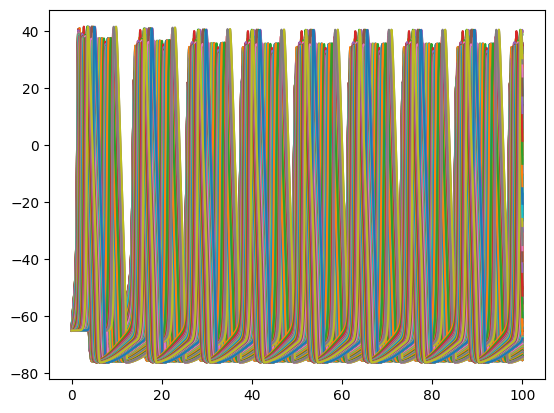

In [6]:
for pos in vdata.keys():
    plt.plot(t,vdata[pos])

### Making figures and video
In this cell I make a space plot of the data through time. 
The images are saved to an output folder called 'images', this folder should have been made earlier in the notebook.
NOTE: this will take some time, but in principle one could use the video for visualization purposes or for a paper


In [7]:
# x,y,z
xp=[]; yp=[]; zp=[];
dat=[];

# collect the coordinates
for p in vdata.keys():
    xp.append(p[0]); yp.append(p[1]); zp.append(p[2])

# how often should we save a figure
fig_every=5;
cnt=0

print('Frame: ',end=' ')
for i in range(len(t)):
    dat=[]
    for p in vdata.keys():
        vv=vdata[p];
        dat.append(vv[i])
    if (i % fig_every == 0):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(xp,yp,zp,c=dat,vmin=-80, vmax=40,cmap='jet')
        plt.title('Time: '+"%.2f"%(round(t[i],3))+'[ms]')
        
        # save the figure into the images directory
        plt.savefig('images/test'+str(cnt)+'.png')
        
        # close the figure, if not you will get a warning!
        plt.close()
        if cnt % 100 == 0: print(cnt,end=' ')
        cnt+=1
        
# make the video
os.system("ffmpeg -r 40 -i images/test%01d.png -vcodec mpeg4 -y movie.mp4")

Frame:  0 100 200 300 400 500 600 700 800 

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0